In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('/home/wtim/neural-capability-maps/')

In [3]:
import os
import torch
import pickle
from pathlib import Path
from tabulate import tabulate
from jaxtyping import Float
from torch import Tensor
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation

import data_sampling.se3 as se3
from data_sampling.sample_morph import sample_morph
from data_sampling.representations import rotation_matrix_to_rotation_vector, vector_to_homogeneous, homogeneous_to_vector
from data_sampling.estimate_workspace import estimate_workspace, estimate_workspace_analytically, create_index, predict
from data_sampling.robotics import inverse_kinematics
from neural_capability_maps.model import load_model
from neural_capability_maps.train import calculate_metrics
from neural_capability_maps.dataset import SingleDataset
from tests.visualisation import visualise, visualise_workspace, visualise_predictions

/home/wtim/.conda/envs/neural-capability-maps/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
torch.manual_seed(0)

# Check Sampling isolated

## Generate Test Morphologies

In [5]:
morphs = [sample_morph(1, i, True)[0] for i in range(1, 7)]

## Generate Test Poses & Ground-Truth

In [6]:
poses = []
ground_truth = []
for morph in morphs:
    label, pose = estimate_workspace_analytically(morph, 100_000)
    poses += [pose]
    ground_truth += [label.squeeze().long()]

## Predict via Discretisation

In [7]:
def evaluate_predictions(pred_list: list[Float[Tensor, "n_pred"]],gt = None ,indices: list[int] = None):
    tp = []
    tn = []
    fp = []
    fn = []
    acc = []
    if gt is None:
        gt = ground_truth

    if indices is not None:
        local_ground_truth = [gt[i] for i in range(len(gt)) if i in indices]
    else:
        local_ground_truth = gt
    for pred, true in zip(pred_list, local_ground_truth):
        true_positives, true_negatives, false_positives, false_negatives, accuracy = calculate_metrics(pred, true)
        tp += [true_positives]
        tn += [true_negatives]
        fp += [false_positives]
        fn += [false_negatives]
        acc += [accuracy]

    headers = ["True Positives", "True Negatives", "False Positives", "False Negatives", "Accuracy"]
    table = list(zip(tp, tn, fp, fn, acc))
    print(tabulate(table, headers=headers, floatfmt=".2f"))

In [9]:
discretisation_labels = []
discretisation_cell_indices = []
discretisation_pred = []
for morph, query_pose in zip(morphs, poses):
    labels, cell_indices = estimate_workspace(morph)

    new_poses = se3.cell(cell_indices)
    new_index = create_index(new_poses)

    pred = predict(new_index, labels, new_poses, query_pose)

    discretisation_labels += [labels]
    discretisation_cell_indices += [cell_indices]
    discretisation_pred += [pred]

W1212 16:22:53.028566 1545858 cuda_executor.cc:1802] GPU interconnect information not available: INTERNAL: NVML library doesn't have required functions.
W1212 16:22:53.232388 1545859 cuda_executor.cc:1802] GPU interconnect information not available: INTERNAL: NVML library doesn't have required functions.
W1212 16:22:53.245164 1543137 cuda_executor.cc:1802] GPU interconnect information not available: INTERNAL: NVML library doesn't have required functions.
W1212 16:22:53.249325 1543137 cuda_executor.cc:1802] GPU interconnect information not available: INTERNAL: NVML library doesn't have required functions.


[auto-batch] est. bytes/sample: 4345 (4.24 KiB), free: 26.73 GiB, safety: 0.5, batch_size: 3302531


WARNING clustering 437 points to 20 centroids: please provide at least 780 training points


[auto-batch] est. bytes/sample: 2942 (2.87 KiB), free: 26.60 GiB, safety: 0.5, batch_size: 4854297
[auto-batch] est. bytes/sample: 6106 (5.96 KiB), free: 26.34 GiB, safety: 0.5, batch_size: 2316235
[auto-batch] est. bytes/sample: 9774 (9.54 KiB), free: 26.34 GiB, safety: 0.5, batch_size: 1446673
[auto-batch] est. bytes/sample: 14954 (14.60 KiB), free: 26.32 GiB, safety: 0.5, batch_size: 945061
[auto-batch] est. bytes/sample: 21006 (20.51 KiB), free: 26.30 GiB, safety: 0.5, batch_size: 672132


In [20]:
[l.shape for l in discretisation_labels]

[torch.Size([437]),
 torch.Size([16781]),
 torch.Size([377923]),
 torch.Size([231555]),
 torch.Size([1667029]),
 torch.Size([710835])]

In [15]:
evaluate_predictions(discretisation_pred)

  True Positives    True Negatives    False Positives    False Negatives    Accuracy
----------------  ----------------  -----------------  -----------------  ----------
           14.17            100.00               0.00              85.83       57.09
           50.32             99.98               0.02              49.68       75.15
           95.14             99.17               0.83               4.86       97.15
           97.08             99.38               0.62               2.92       98.23
           99.91             90.94               9.06               0.09       95.42
           99.81             96.87               3.13               0.19       98.34


# Examine Training Data

In [5]:
train_dataset = SingleDataset(Path(os.getcwd()).parent / "data" / "train", 1000, False)
training_data = torch.from_numpy(train_dataset.root[train_dataset.keys[0]][:])

val_dataset = SingleDataset(Path(os.getcwd()).parent / "data" / "val", 1000, False)
validation_data = torch.from_numpy(val_dataset.root[val_dataset.keys[0]][:])

In [6]:
training_morph = train_dataset.morphologies[training_data[0, -1].long()]
training_poses = se3.cell(training_data[:, 1])
training_labels = training_data[:, 0]

In [7]:
val_morph = val_dataset.morphologies[validation_data[0, -1].long()]
val_poses = vector_to_homogeneous(validation_data[:, 1:-1])
val_labels = validation_data[:, 0]

In [30]:
# what is the error rate of this actually?
from data_sampling.robotics import analytical_inverse_kinematics
_, true = analytical_inverse_kinematics(training_morph[:-1, :], training_poses[:2000])

In [32]:
true_labels = true != -1

In [33]:
true_labels

tensor([False, False, False,  ...,  True, False, False])

In [35]:
(true_labels != training_labels[:2000].bool()).sum()

tensor(516)

In [50]:
se3.cell_vec(training_data[:2000, 1]).unique(dim=0)

tensor([[-0.6389,  0.0278, -0.1944,  ...,  0.3090,  0.9032, -0.2979],
        [-0.5833, -0.1389, -0.4722,  ..., -0.5182,  0.8537,  0.0523],
        [-0.5833, -0.1389, -0.1944,  ...,  0.8214, -0.4183,  0.3878],
        ...,
        [ 0.2500, -0.0278, -0.1389,  ..., -0.2387, -0.9699, -0.0487],
        [ 0.2500,  0.1944, -0.1389,  ..., -0.8090,  0.5219,  0.2703],
        [ 0.3056,  0.0278, -0.2500,  ...,  0.1967,  0.9774,  0.0777]])

In [13]:
train_index = create_index(training_poses)
data_pred = predict(train_index, training_labels, training_poses, val_poses)
evaluate_predictions([data_pred], [val_labels])

  True Positives    True Negatives    False Positives    False Negatives    Accuracy
----------------  ----------------  -----------------  -----------------  ----------
           23.55             99.09               0.91              76.45       61.32


## Predict with the trained classifier

In [16]:
model = load_model(805)
model.eval()

morph = val_morph.repeat(val_poses.shape[0], 1, 1).to("cuda")
pose = homogeneous_to_vector(val_poses).to("cuda")
with torch.no_grad():
    classifier_pred = model(pose, morph).cpu().squeeze()
morph = morph.cpu()
pose = pose.cpu()

In [17]:
evaluate_predictions([classifier_pred], [val_labels])

  True Positives    True Negatives    False Positives    False Negatives    Accuracy
----------------  ----------------  -----------------  -----------------  ----------
           96.88             99.57               0.43               3.12       98.22


In [18]:
preds = []
labels = []
for morph, pose, label in train_dataset:
    morph = morph.to("cuda", non_blocking=True)
    pose = pose.to("cuda", non_blocking=True)
    label = label.to("cuda", non_blocking=True)
    model.eval()
    with torch.no_grad():
        pred = model(pose, morph)
    preds.append(pred.cpu())
    labels.append(label.cpu())
preds = torch.cat(preds, dim=0)
labels = torch.cat(labels, dim=0)

In [19]:
evaluate_predictions([preds], [labels])

  True Positives    True Negatives    False Positives    False Negatives    Accuracy
----------------  ----------------  -----------------  -----------------  ----------
           21.40             85.24              14.76              78.60       53.32


# Qualitative Analysis

## Generate Test Poses

In [17]:
num_geodesics = 3
line_samples = 5000

directions = se3.random(num_geodesics)

batched_origin = torch.eye(4).repeat(num_geodesics, 1, 1)
axis_angle = rotation_matrix_to_rotation_vector(directions[:, :3, :3])
flat_pose = torch.cat([axis_angle, directions[:, :3, 3]], dim=1) / se3.distance(directions, batched_origin)
flat_pose /= flat_pose[:, 3:].norm(dim=1, keepdim=True)

t = torch.arange(0, 1, 1 / line_samples).repeat(num_geodesics, 1)
lines = t.unsqueeze(2) * flat_pose.unsqueeze(1)

line_poses = torch.eye(4).repeat(num_geodesics, line_samples, 1, 1)
line_poses[:, :, :3, :3] = Rotation.from_rotvec(lines[:, :, :3].reshape(-1, 3)).as_matrix().reshape(
    *lines[:, :, :3].shape[0:2], 3, 3)
line_poses[:, :, :3, 3] = lines[:, :, 3:]

## Generate Ground-Truth

In [18]:
ground_truth_line = inverse_kinematics(training_morph[:-1, :], line_poses.view(-1, 4, 4))[1].reshape(num_geodesics, line_samples)
ground_truth_line[ground_truth_line != -1] = 1.0
ground_truth_line[ground_truth_line == -1] = 0.0

NameError: name 'training_morph' is not defined

In [42]:
morph = training_morph.repeat(line_samples * num_geodesics, 1, 1).to("cuda")
pose = homogeneous_to_vector(line_poses.view(-1, 4, 4)).to("cuda")
with torch.no_grad():
    line_pred = model(pose, morph).cpu().squeeze()
morph = morph.cpu()
pose = pose.cpu()

line_pred = (torch.nn.Sigmoid()(line_pred.reshape(num_geodesics, line_samples)) > 0.5).long()

In [44]:
evaluate_predictions([line_pred], [ground_truth_line])

  True Positives    True Negatives    False Positives    False Negatives    Accuracy
----------------  ----------------  -----------------  -----------------  ----------
           68.88             86.40              13.60              31.12       77.64


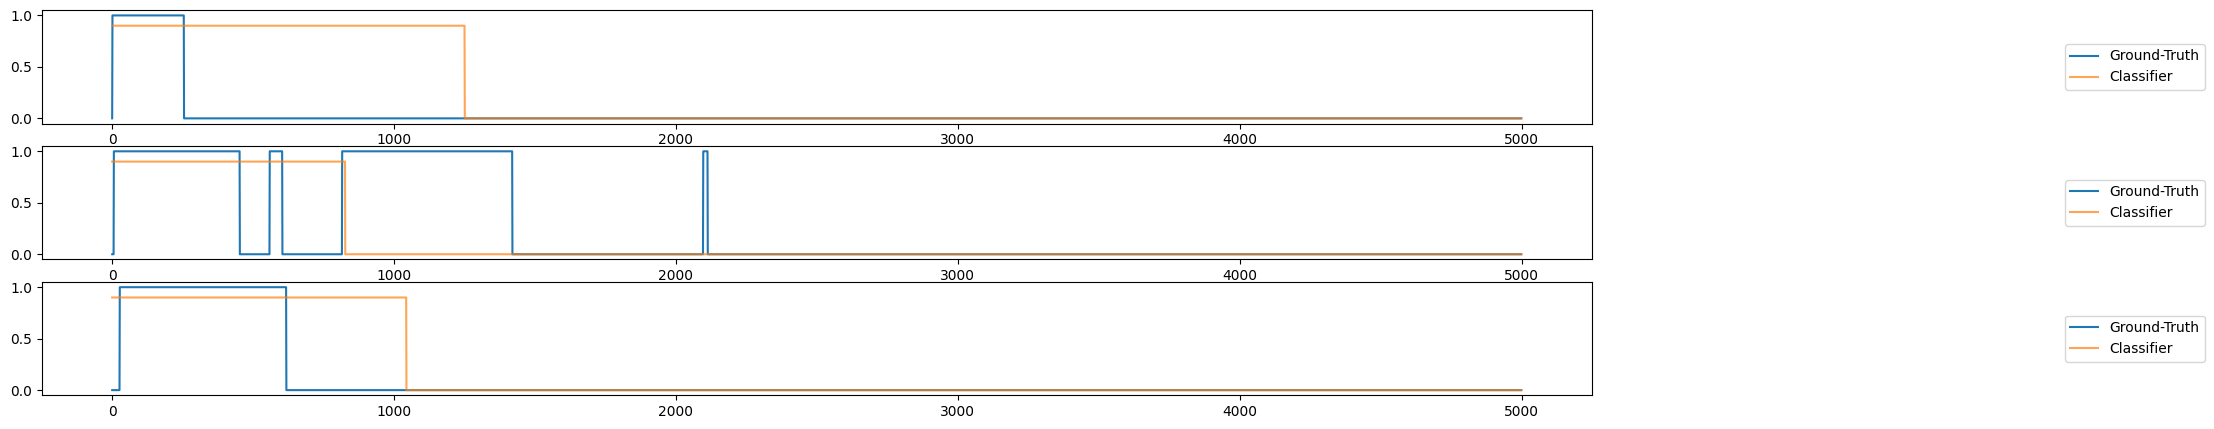

In [43]:
# Plot
fig, axes = plt.subplots(num_geodesics, figsize=(20, 5))

for i in range(num_geodesics):
    axes[i].plot(ground_truth_line[i], label="Ground-Truth")
    axes[i].plot(line_pred[i]*0.9, label="Classifier", alpha=0.7)
    axes[i].legend(loc="right", bbox_to_anchor=(1.4, 0.5))
plt.show()